# Lab 9b: Payoff and Profit of Composite Contracts at Expiration
Call and put contracts can be combined to develop composite contract structures with interesting payoff diagrams. Let's limit our focus to contracts that have the same underlying asset and the same expiration date. A composite option contract be composed of $d$ legs (individual contracts) in the contract set $\mathcal{C}$ where each leg $i\in\mathcal{C}$ is written with respect to the same underlying stock `XYZ` and has the same expiration date. Then, the overall payoff of the composite contract $\hat{V}(S(T),K_{1},\dots,K_{d})$ is given by:


$$\hat{V}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}V_{i}(S(T),K_{i})$$


where $K_{i}$ denotes the strike price of contract $i\in\mathcal{C}$. The overall profit of the composite contract $\hat{P}$ is given by:


$$\hat{P}(S(T),K_{1},\dots,K_{d}) = \sum_{i\in\mathcal{C}}\theta_{i}n_{i}P_{i}(S(T),K_{i})$$


where $\theta_{i}$ denotes the direction of contract $i$: if contract $i$ is short (sold), then $\theta_{i}=-1$, otherwise $\theta_{i}=1$, $n_{i}$ denotes the copy number of contract $i$, ${V}_{i}(S(T),K_{i})$ denotes the payoff of contract $i$, and $P_{i}(S(T),K_{i})$ denotes the profit of contract $i$. Finally, the profit for contract of type $\star$ is given by:

$$P_{\star}(K,S(T)) = {V}_{\star}(K,S(T)) -  \mathcal{P}_{\star}(K,S(0))$$

where $\mathcal{P}_{\star}(K,S(0))$ denotes the premium of contract $\star$, and ${V}_{\star}(K,S(T))$ denotes the payoff of contract $\star$ at expiration.


## Learning Objectives
For this example, we will compute the profit diagrams at expiration for some common composite contracts. We downloaded the options chain (premium value versus as a function of strike price) for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) from [barchart.com](https://www.barchart.com). In this example, the share price of `AMD` is `S(0) = 117.50 USD/share`, and the average implied volatility for `AMD` options with `DTE = 31 days` is `IV = 51.75%`.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

In [2]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Labs-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Labs-F23/Manifest.toml`


### Constants

In [22]:
Sₒ = 117.50; # initial share price
number_of_steps = 1001;
β₁ = 0.70;
β₂ = 1.30;
β = range(β₁, stop = β₂, length = number_of_steps) |> collect;

## Prerequisite: Load options chain dataset
To start, load the options data using using the `MyOptionsChainDataSet(...)` function and store the data in the `options_dataset` variable:

In [3]:
options_dataset = MyOptionsChainDataSet();

## Task 1: Short straddle on `AMD` with `31-DTE`

A [straddle](https://www.investopedia.com/terms/s/straddle.asp) is a _neutral strategy_ constructed by simultaneously buying (or selling) a put and a call option on the same underlying asset `XYZ`, with the _same expiration_, and the _same strike price_. Depending upon the choice of the strike prices and whether an investor buys or sells both legs, a [straddle](https://www.investopedia.com/terms/s/straddle.asp) can be initiated as a credit or debit and can potentially have undefined profit or loss.

Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the price of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the `put` contract, $j=2$ denote the `call` contract; for a straddle $K_{1}= K_{2}\equiv{K}$ (both legs have the same strike). The profit for a single straddle contract $\hat{P}$ at expiration is given by:

$$\hat{P} = \theta\cdot\left(P_{1}+P_{2}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a `put` and a `call` contract, the overall profit $\hat{P}$ is given by:

$$\hat{P} = \theta\cdot\Bigl[(K-S)^{+}+(S-K)^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p} = (K-S)^{+}=\max(K-S,0)$ is the payoff function for the `put` contract, and $V_{c} = (S-K)^{+} = \max(S-K,0)$ is the payoff function for the `call` contract. The profit (or loss) of a straddle has three regimes given by:

$$
\hat{P} = \begin{cases}
  \theta\cdot\Bigl[(S-K)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S>K \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & S=K \\
    \theta\cdot\Bigl[(K-S)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S<K
\end{cases}
$$

Finally, a straddle has _two_ possible breakeven points denoted as $S^{+}$ and $S^{-}$:
* If $S>K$: a straddle will breakeven at $S^{+} = K + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$
* If $S<K$: a straddle will breakeven at $S^{-} = K - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$.

#### Short straddle
For a short straddle, we sell (are short) both the `put` and the `call` contracts in the straddle, thus $\theta = 1$. Let's contruct the profit diagram for a short straddle with the parameters:

* Leg 1: The strike price for the `short put` leg is given by $K_{1}$ = `K` USD/share with `DTE = 31 days`
* Leg 2: The strike price for the `short call` leg is given by $K_{2}$ = `K` USD/share with `DTE = 31 days`

Set the strike price `K` of the short `call` and `put` legs:

In [4]:
K = 120.0; 

Next, let's use the `build(...)` method to construct instances of the `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models, which we'll use to model the contracts. 
* However, before can do that, need to lookup the premium from the `options_dataset` for each of these contracts using the `filter(...)` command publichsed by the [DataFrames.jl](https://dataframes.juliadata.org/stable/) package:

In [6]:
premium_put_straddle = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Midpoint];
premium_call_straddle = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Midpoint];

Now we can construct the contract models using the `build(...)` method. To do the profit diagram calculation at expiration, we need to pass in a few peices of information into the `build(...)` method:

* The profit diagram calculation requires that we pass in the strike price `K`, the `premium` value, the `sense`, and the number of contracts in the `copy` parameter

In [8]:
straddle_put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium_put_straddle, sense = -1, copy = 1
));

staddle_call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium_call_straddle, sense = -1, copy = 1
));

Next, we constract an array of share prices for `AMD` at expiration, store this in the `share_price_array` variable. I'm `flexing` a little by using a short-cut syntax called an [Array comprehension](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) to populate the `share_price_array` array:

In [23]:
share_price_array = [Sₒ*β[i] for i ∈ eachindex(β)];

Finally, we can compute the `profit` for the `AMD` short straddle by calling the `profit(...)` function. In particular, we pass in:
* Pass in an array of contract models, and the `share_price_array` and we get back an array holding the share price in `col 1`, the P/L for each leg in `col 2 ... col C` and the overall P/L in the last column.

In [24]:
profit_array = profit([straddle_put_contract_model, staddle_call_contract_model], share_price_array);

### Visualize

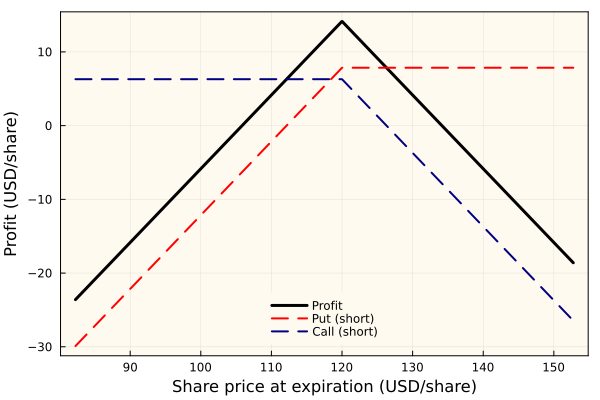

In [26]:
 plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent,
        legend=:bottom)
plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:red)
plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call (short)", ls=:dash, c=:navyblue)
xlabel!("Share price at expiration (USD/share)", fontsize=18)
ylabel!("Profit (USD/share)", fontsize=18)